# Notebook 03 — Feature Exploration

This notebook inspects latent representations (SVD scores/residuals, AE outputs) and hybrid risk. It helps validate that the learned features capture signal (structure in scores/residuals) and that hybrid risk correlates with deficits across train/val/test, providing intuition and sanity checks before deployment.

## Mathematical overview and notation

- **Splits**: `val` and `test` sets come from distinct years; `train` is earlier-season data (no leakage).
- **Indices**: NDVI (Normalized Difference Vegetation Index) and NDRE (Normalized Difference Red Edge) are per-pixel reflectance ratios; higher values generally mean healthier canopy.
- **SVD (rank-1 here)**: We decompose the temporal stack into a dominant temporal **score** (per sample) and a **residual** (what the score cannot explain). Small, structured residuals mean the first component captures most variance.
- **Labels**: `y_train`, `y_val`, `y_te` are binary deficit indicators (1 = nitrogen deficit, 0 = healthy) built from NDRE quantiles in the dataset stage.
- **Hybrid risk**: Probabilities from the CatBoost + residual fusion; higher means more likely deficit.
- **Plots/outputs in this notebook**: residual norm density (train/val/test), SVD score view by split/label (PCA if ≥2 dims), hybrid risk vs. residual scatter, hybrid risk distribution by split/label, quantitative summary table (means + AUC/AP) showing how scores/residuals/hybrid risk align with labels.

# 03 – Feature Visualization

Explore SVD components, scores, residuals, and hybrid risk. Assumes `train_temporal_hybrid` has been run.

In [32]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

sns.set_style("whitegrid")

INTERIM = Path('data/interim')
splits = ['train', 'val', 'test']

svd_scores = {split: np.load(INTERIM / f'svd_scores_{split}.npy') for split in splits}
residuals = {split: np.load(INTERIM / f'svd_residual_norm_{split}.npy') for split in splits}
hybrid_risk = {split: np.load(INTERIM / f'hybrid_risk_{split}.npy') for split in splits}
label_files = {'train': 'y_train_deficit_label.npy', 'val': 'y_val_deficit_label.npy', 'test': 'y_test_deficit_label.npy'}
labels = {split: np.load(INTERIM / fname) for split, fname in label_files.items()}

with open(INTERIM / 'svd_meta.json') as f:
    svd_meta = json.load(f)

def stack_by_split(d):
    return np.concatenate([d[s] for s in splits])

n_features = svd_scores['train'].shape[1]
split_column = np.concatenate([[s] * len(labels[s]) for s in splits])

label_palette = {'healthy': '#2a9d8f', 'deficit': '#e63946'}

df_all = pd.DataFrame({
    'split': split_column,
    'label': stack_by_split(labels),
    'svd_score': np.concatenate([svd_scores[s][:, 0] for s in splits]),
    'residual': stack_by_split(residuals),
    'hybrid_risk': stack_by_split(hybrid_risk),
})
df_all['label_name'] = df_all['label'].map({0: 'healthy', 1: 'deficit'})

Residual norm distribution (what it shows)

For each field, we project its 5-step NDRE onto the “healthy” temporal SVD basis, reconstruct the expected curve, and take the residual (r = x - \hat{x}).

The residual norm (a = |r|_2) is a single stress scalar: bigger means the field’s NDRE shape (timing/height) departs more from the healthy backbone.

The plot is a smooth density (KDE) of these (a) values for train/val/test. Tall areas mean “many fields have a residual norm around here”; long tails show rarer, off-curve phenology.

We look at this to

(1) see how typical each split is relative to the healthy pattern,

(2) spot outliers to filter, and

(3) confirm the residual-based stress signal we feed into CatBoost and the hybrid fusion.

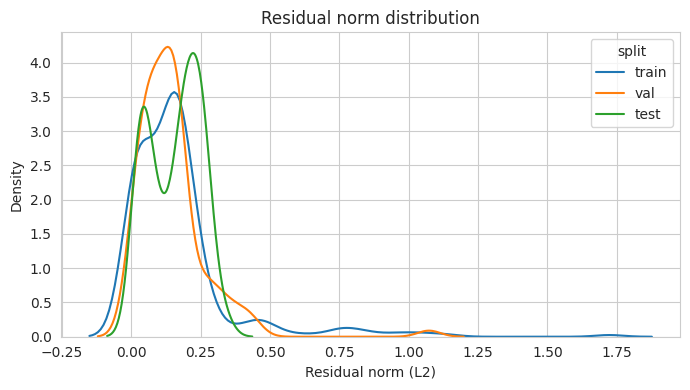

In [33]:
# Residual distributions
plt.figure(figsize=(7, 4))
for split, color in zip(splits, ['#577590', '#f3a712', '#43aa8b']):
    sns.kdeplot(residuals[split], label=split, bw_adjust=0.8)
plt.title('Residual norm distribution')
plt.xlabel('Residual norm (L2)')
plt.legend(title='split')
plt.tight_layout()
plt.show()

/tmp/ipykernel_2934077/649418462.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[-1].legend(title='label', bbox_to_anchor=(1.02, 1), borderaxespad=0)


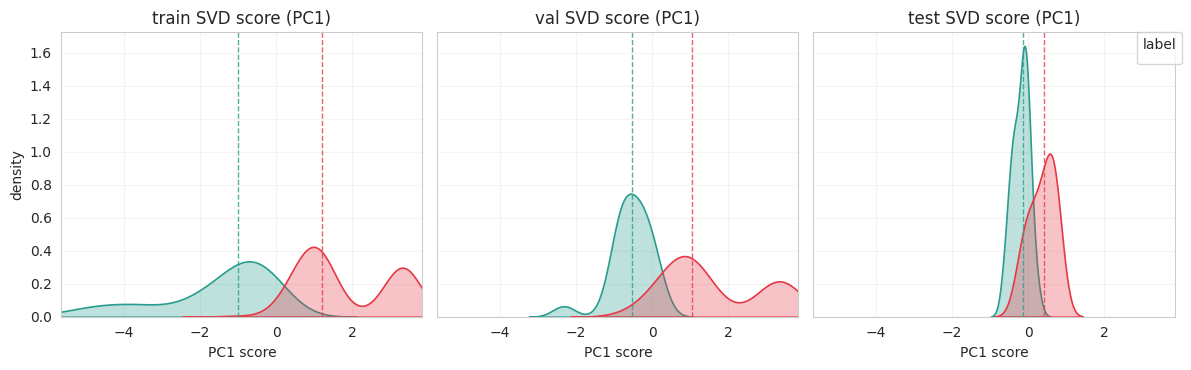

In [34]:
# SVD score visualization (train/val/test)
# If only one feature is available, show per-split KDEs with shared limits
X = np.vstack([svd_scores[s] for s in splits])
labels_array = stack_by_split(labels)
split_array = split_column

if n_features >= 2:
    pca = PCA(n_components=2)
    Z = pca.fit_transform(X)
    embed_df = pd.DataFrame({
        'pc1': Z[:, 0],
        'pc2': Z[:, 1],
        'split': split_array,
        'label_name': np.where(labels_array == 1, 'deficit', 'healthy'),
    })
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        data=embed_df, x='pc1', y='pc2',
        hue='label_name', style='split',
        palette=label_palette, alpha=0.7, s=55
    )
    plt.title('PCA of SVD scores by split/label')
    plt.tight_layout()
    plt.show()
else:
    lo, hi = np.percentile(df_all['svd_score'], [1, 99])
    pad = 0.5
    xlim = (lo - pad, hi + pad)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.8), sharey=True)
    for ax, split in zip(axes, splits):
        subset = df_all[df_all.split == split]
        for label_name, color in label_palette.items():
            sublab = subset[subset.label_name == label_name]['svd_score']
            if len(sublab) == 0:
                continue
            sns.kdeplot(sublab, fill=True, alpha=0.3, bw_adjust=1.1, color=color, linewidth=1.2, ax=ax)
            ax.axvline(sublab.median(), color=color, linestyle='--', alpha=0.8, linewidth=1.0)
        ax.set_title(f"{split} SVD score (PC1)")
        ax.set_xlim(xlim)
        ax.set_xlabel('PC1 score')
        ax.grid(alpha=0.2)
    axes[0].set_ylabel('density')
    axes[-1].legend(title='label', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    plt.tight_layout()
    plt.show()

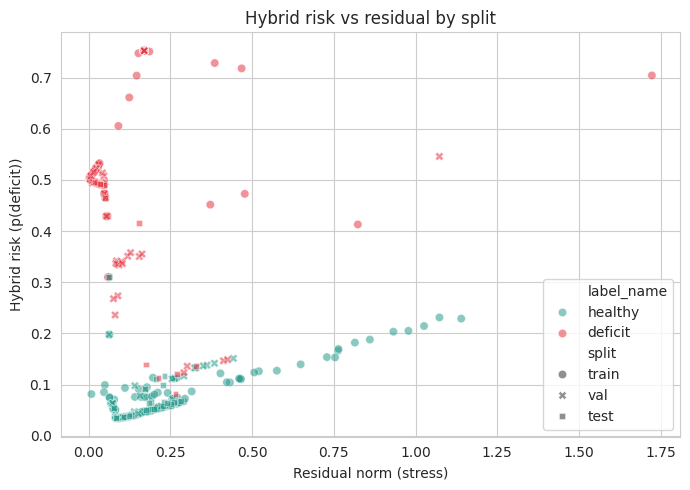

In [35]:
# Hybrid risk vs. residual (train/val/test)
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=df_all, x='residual', y='hybrid_risk',
    hue='label_name', style='split',
    palette=label_palette, alpha=0.55
)
plt.xlabel('Residual norm (stress)')
plt.ylabel('Hybrid risk (p(deficit))')
plt.title('Hybrid risk vs residual by split')
plt.tight_layout()
plt.show()

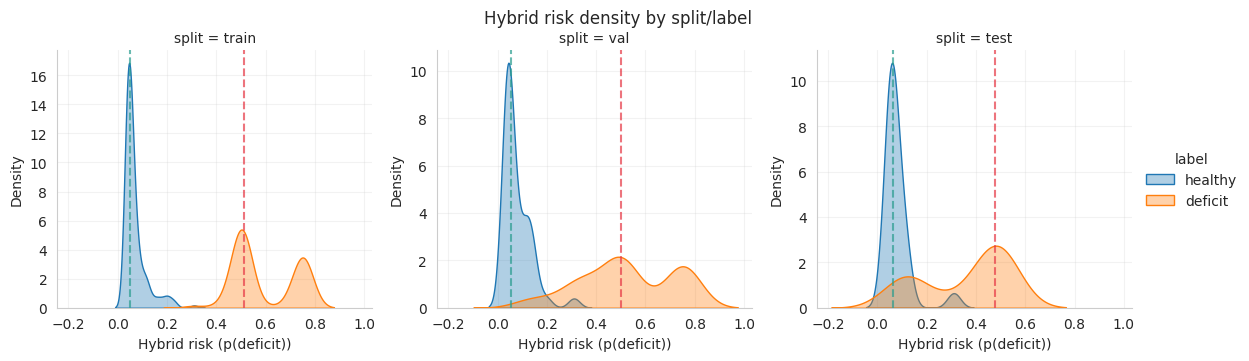

In [36]:
# Hybrid risk distribution by split/label (density view)
g = sns.FacetGrid(df_all, col='split', hue='label_name', sharex=True, sharey=False, height=3.5, aspect=1.1)
g.map(sns.kdeplot, 'hybrid_risk', fill=True, alpha=0.35, bw_adjust=0.9)
# Mark medians per split/label
for ax, split in zip(g.axes.flat, splits):
    subset = df_all[df_all.split == split]
    for label_name, color in label_palette.items():
        med = subset[subset.label_name == label_name]['hybrid_risk'].median()
        if np.isfinite(med):
            ax.axvline(med, color=color, linestyle='--', alpha=0.7)
        ax.set_xlabel('Hybrid risk (p(deficit))')
    ax.grid(alpha=0.25)
g.add_legend(title='label')
g.fig.suptitle('Hybrid risk density by split/label', y=1.02)
plt.show()

## Quantitative summary (train/val/test)

Scores separate deficits from healthy samples, residuals grow with stress, and hybrid risk tracks both. The table below reports mean separation and AUC/AP for each signal (SVD score flipped so higher = deficit) per split.

In [37]:
from sklearn.metrics import roc_auc_score, average_precision_score

def safe_auc(y, score):
    return roc_auc_score(y, score) if y.nunique() > 1 else float('nan')

def safe_ap(y, score):
    return average_precision_score(y, score) if y.nunique() > 1 else float('nan')

def summarize(group):
    return pd.Series({
        'n': len(group),
        'pos_rate': group['label'].mean(),
        'svd_mean_deficit': group.loc[group.label == 1, 'svd_score'].mean(),
        'svd_mean_healthy': group.loc[group.label == 0, 'svd_score'].mean(),
        'resid_mean_deficit': group.loc[group.label == 1, 'residual'].mean(),
        'resid_mean_healthy': group.loc[group.label == 0, 'residual'].mean(),
        'hybrid_mean_deficit': group.loc[group.label == 1, 'hybrid_risk'].mean(),
        'hybrid_mean_healthy': group.loc[group.label == 0, 'hybrid_risk'].mean(),
        'svd_auc(deficit)': safe_auc(group['label'], -group['svd_score']),
        'svd_ap(deficit)': safe_ap(group['label'], -group['svd_score']),
        'resid_auc(deficit)': safe_auc(group['label'], group['residual']),
        'resid_ap(deficit)': safe_ap(group['label'], group['residual']),
        'hybrid_auc(deficit)': safe_auc(group['label'], group['hybrid_risk']),
        'hybrid_ap(deficit)': safe_ap(group['label'], group['hybrid_risk']),
    })

summary = df_all.groupby('split').apply(summarize).round(3).reindex(splits)
summary

/tmp/ipykernel_2934077/1359268219.py:27: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df_all.groupby('split').apply(summarize).round(3).reindex(splits)


,n,pos_rate,svd_mean_deficit,svd_mean_healthy,resid_mean_deficit,resid_mean_healthy,hybrid_mean_deficit,hybrid_mean_healthy,svd_auc(deficit),svd_ap(deficit),resid_auc(deficit),resid_ap(deficit),hybrid_auc(deficit),hybrid_ap(deficit)
split,,,,,,,,,,,,,,
train,317.0,0.470,1.814,-1.609,0.100,0.227,0.591,0.068,0.003,0.300,0.225,0.386,1.000,1.000
val,108.0,0.602,1.611,-0.556,0.127,0.173,0.521,0.077,0.015,0.409,0.351,0.582,0.992,0.995
test,39.0,0.410,0.365,-0.195,0.110,0.189,0.358,0.077,0.090,0.264,0.255,0.406,0.965,0.954
